# Join the two datasets

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

In [2]:
import os

os.getcwd()

'C:\\Users\\anton\\Big-Data-Analytics-Group-Project'

#### Load datasets:

In [3]:
df_hourly_weather = pd.read_pickle('datasets/hourly_weather.pkl')
df_accidents = pd.read_pickle("datasets/accidents.pkl")

In [4]:
df_hourly_weather.columns

Index(['date', 'air_temperature', 'water_temperature', 'wind_gust_max_10min',
       'wind_speed_avg_10min', 'wind_force_avg_10min', 'wind_direction',
       'windchill', 'barometric_pressure_qfe', 'precipitation', 'dew_point',
       'global_radiation', 'humidity', 'water_level'],
      dtype='object')

In [5]:
df_accidents.columns

Index(['date', 'AccidentType', 'AccidentSeverityCategory',
       'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
       'AccidentInvolvingMotorcycle', 'RoadType', 'AccidentLocation_CHLV95_E',
       'AccidentLocation_CHLV95_N', 'Month', 'WeekDay', 'Hour'],
      dtype='object')

### I) Merge the two datasets

In [6]:
df_join = pd.merge(df_hourly_weather, df_accidents, on='date', how='left')
df_join.shape

(92081, 25)

### II) Normalization and One Hot Encoding

#### One Hot Encoding of categorical cols and normalization:

Notes: 
<br>
$a)$ One Hot Encoding for vars of type object
<br>
$b)$ AccidentLocation should be normalized because too many different categories

In [7]:
df_join['Month'].fillna(df_join['date'].dt.month, inplace = True)
df_join['Hour'].fillna(df_join['date'].dt.hour, inplace = True)
df_join['WeekDay'].fillna(df_join['date'].dt.day_name(), inplace = True)
df_join.tail()

,date,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,...,AccidentSeverityCategory,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,RoadType,AccidentLocation_CHLV95_E,AccidentLocation_CHLV95_N,Month,WeekDay,Hour
92076,2019-12-31 18:30:00,1.56,6.80,2.3,1.24,1.0,734,1.54,984.54,0.0,...,as4,0.0,0.0,0.0,rt432,2682276.0,1247052.0,12.0,Tuesday,18.0
92077,2019-12-31 19:30:00,1.34,6.80,2.6,1.44,1.2,963,1.18,984.62,0.0,...,as4,0.0,0.0,0.0,rt433,2683004.0,1247184.0,12.0,Tuesday,19.0
92078,2019-12-31 20:30:00,1.04,6.80,2.8,1.66,1.8,699,0.78,984.76,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,Tuesday,20.0
92079,2019-12-31 21:30:00,1.06,6.76,2.5,1.36,1.2,729,1.00,984.84,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,Tuesday,21.0
92080,2019-12-31 22:30:00,0.48,6.70,4.6,3.12,2.2,293,-3.60,985.02,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,Tuesday,22.0


In [8]:
df_join['wind_direction'] = [int(df_join['wind_direction'][i]) for i in range(len(df_join))]   

In [9]:
#one hot encoding for cols that need to be transformed (drop one of each category later)
categorical_cols = list(df_join.select_dtypes(include=['object']).columns)
categorical_cols.extend(['Month', 'Hour']) # these need to be one hot encoded as well
df_join = pd.get_dummies(df_join, columns = categorical_cols, dtype= bool, drop_first= True)
df_join.columns

Index(['date', 'air_temperature', 'water_temperature', 'wind_gust_max_10min',
       'wind_speed_avg_10min', 'wind_force_avg_10min', 'wind_direction',
       'windchill', 'barometric_pressure_qfe', 'precipitation', 'dew_point',
       'global_radiation', 'humidity', 'water_level',
       'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
       'AccidentInvolvingMotorcycle', 'AccidentLocation_CHLV95_E',
       'AccidentLocation_CHLV95_N', 'AccidentType_at00', 'AccidentType_at1',
       'AccidentType_at2', 'AccidentType_at3', 'AccidentType_at4',
       'AccidentType_at5', 'AccidentType_at6', 'AccidentType_at7',
       'AccidentType_at8', 'AccidentType_at9', 'AccidentSeverityCategory_as2',
       'AccidentSeverityCategory_as3', 'AccidentSeverityCategory_as4',
       'RoadType_rt431', 'RoadType_rt432', 'RoadType_rt433', 'RoadType_rt434',
       'RoadType_rt439', 'WeekDay_Monday', 'WeekDay_Saturday',
       'WeekDay_Sunday', 'WeekDay_Thursday', 'WeekDay_Tuesday',
       'WeekDay_We

Note: 
<br>
Since there are too many different locations in 'AccidentLocation_CHLV95_E' and 'AccidentLocation_CHLV95_N', it would be inappropriate to one hot encode these... So instead we will normalize them.
<br>
We will nevertheless check the distribution of accidents across locations because it might offer some insight regarding locations that are more dangerous...

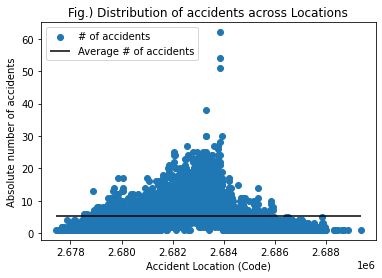

In [10]:
import matplotlib.pyplot as plt
location_dict = df_join['AccidentLocation_CHLV95_E'].value_counts().to_dict()
plt.title('Fig.) Distribution of accidents across Locations')
plt.scatter(location_dict.keys(), location_dict.values(), label = '# of accidents')
plt.ylabel('Absolute number of accidents')
plt.xlabel('Accident Location (Code)')
plt.hlines(np.mean(list(location_dict.values())), min(list(location_dict.keys())), 
           max(list(location_dict.keys())), color = 'black', label = 'Average # of accidents')
plt.legend(loc = 'best')

#normalize values of accident locations
from sklearn import preprocessing
column_E, column_N = np.array(df_join.pop('AccidentLocation_CHLV95_E')), np.array(df_join.pop('AccidentLocation_CHLV95_N'))
index_column_E, index_column_N = df_join.columns.get_loc(column_E), df_join.columns.get_loc(column_N)
normalized_E, normalized_N = preprocessing.normalize([column_E]), preprocessing.normalize([column_N])
df_join.insert(index_column_E, 'AccidentLocation_CHLV95_E', normalized_E.reshape(-1,1))
df_join.insert(index_column_N, 'AccidentLocation_CHLV95_N', normalized_N.reshape(-1,1))

In [11]:
df_join.columns

Index(['date', 'air_temperature', 'water_temperature', 'wind_gust_max_10min',
       'wind_speed_avg_10min', 'wind_force_avg_10min', 'wind_direction',
       'windchill', 'barometric_pressure_qfe', 'precipitation', 'dew_point',
       'global_radiation', 'humidity', 'water_level',
       'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
       'AccidentInvolvingMotorcycle', 'AccidentLocation_CHLV95_E',
       'AccidentLocation_CHLV95_N', 'AccidentType_at00', 'AccidentType_at1',
       'AccidentType_at2', 'AccidentType_at3', 'AccidentType_at4',
       'AccidentType_at5', 'AccidentType_at6', 'AccidentType_at7',
       'AccidentType_at8', 'AccidentType_at9', 'AccidentSeverityCategory_as2',
       'AccidentSeverityCategory_as3', 'AccidentSeverityCategory_as4',
       'RoadType_rt431', 'RoadType_rt432', 'RoadType_rt433', 'RoadType_rt434',
       'RoadType_rt439', 'WeekDay_Monday', 'WeekDay_Saturday',
       'WeekDay_Sunday', 'WeekDay_Thursday', 'WeekDay_Tuesday',
       'WeekDay_We

In [12]:
df_join.dtypes

date                    datetime64[ns]
air_temperature                float64
water_temperature              float64
wind_gust_max_10min            float64
wind_speed_avg_10min           float64
                             ...      
Hour_19.0                         bool
Hour_20.0                         bool
Hour_21.0                         bool
Hour_22.0                         bool
Hour_23.0                         bool
Length: 77, dtype: object

#### Convert boolean types from True/False to 1/0:

In [13]:
bool_cols = list(df_join.select_dtypes(include=['bool']).columns)
df_join[bool_cols] = 1*df_join[bool_cols]

In [14]:
df_join['Accident'] = np.where(df_join.isnull().any(axis = 1), 0, 1)
df_join.head()

,date,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,...,Hour_15.0,Hour_16.0,Hour_17.0,Hour_18.0,Hour_19.0,Hour_20.0,Hour_21.0,Hour_22.0,Hour_23.0,Accident
0,2011-01-01 00:30:00,2.233333,5.20,2.4,1.216667,1.216667,1785,2.20,974.55,0.0,...,0,0,0,0,0,0,0,0,0,1
1,2011-01-01 01:30:00,2.380000,5.20,2.8,0.860000,0.860000,1076,2.16,973.98,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2011-01-01 02:30:00,2.580000,5.14,1.2,0.340000,0.340000,1159,2.58,973.64,0.0,...,0,0,0,0,0,0,0,0,0,1
3,2011-01-01 02:30:00,2.580000,5.14,1.2,0.340000,0.340000,1159,2.58,973.64,0.0,...,0,0,0,0,0,0,0,0,0,1
4,2011-01-01 03:30:00,2.500000,5.16,1.9,0.520000,0.520000,1122,2.54,973.42,0.0,...,0,0,0,0,0,0,0,0,0,1


**Notes**: 
<br> 
For neural network we need to normalize the input data while this is not necessary for Random Forest (*also not necessary to one one hot encode the data*)
<br>
Therefore, it would make sense to have different datasets regarding the model type.


In [28]:
unnecessary_cols = [df_join[column].name for column in df_join if df_join[column].name.startswith('Accident') and df_join[column].name != 'Accident']
unnecessary_cols.extend([df_join[column].name for column in df_join if df_join[column].name.startswith('RoadType')])
df_join = df_join.drop(unnecessary_cols, axis = 1)

In [29]:
df_join.columns

Index(['date', 'air_temperature', 'water_temperature', 'wind_gust_max_10min',
       'wind_speed_avg_10min', 'wind_force_avg_10min', 'wind_direction',
       'windchill', 'barometric_pressure_qfe', 'precipitation', 'dew_point',
       'global_radiation', 'humidity', 'water_level', 'WeekDay_Monday',
       'WeekDay_Saturday', 'WeekDay_Sunday', 'WeekDay_Thursday',
       'WeekDay_Tuesday', 'WeekDay_Wednesday', 'Month_2.0', 'Month_3.0',
       'Month_4.0', 'Month_5.0', 'Month_6.0', 'Month_7.0', 'Month_8.0',
       'Month_9.0', 'Month_10.0', 'Month_11.0', 'Month_12.0', 'Hour_1.0',
       'Hour_2.0', 'Hour_3.0', 'Hour_4.0', 'Hour_5.0', 'Hour_6.0', 'Hour_7.0',
       'Hour_8.0', 'Hour_9.0', 'Hour_10.0', 'Hour_11.0', 'Hour_12.0',
       'Hour_13.0', 'Hour_14.0', 'Hour_15.0', 'Hour_16.0', 'Hour_17.0',
       'Hour_18.0', 'Hour_19.0', 'Hour_20.0', 'Hour_21.0', 'Hour_22.0',
       'Hour_23.0', 'Accident'],
      dtype='object')

In [30]:
df_join.to_csv('datasets\\dataset.csv')

#### Trying out if neural network works

In [47]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
import keras
import tensorflow
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [44]:
Y = np.array(df_join['Accident'])
X = np.array(df_join.drop(['Accident', 'date'], 1))
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, Y, test_size=0.2, random_state=2)
scaler = MinMaxScaler()
scaler.fit(X_train_80)
X_train_80 = scaler.transform(X_train_80)
X_test_20 = scaler.transform(X_test_20)

#training and evaluating neural network
NeuralNet = Sequential([
        Dense(16, input_dim= X_train_80.shape[1], activation='sigmoid'),
        Dense(4, activation = 'sigmoid'),
        Dense(1, activation='sigmoid'),
])
NeuralNet.compile(loss ='MSE', optimizer ='adam', metrics = ['accuracy'])
historyNet = NeuralNet.fit(X_train_80, y_train_80, validation_split = 0.2, epochs=100, batch_size=64, 
                              shuffle = False, verbose = 1)
scores = NeuralNet.evaluate(X_test_20, y_test_20, verbose=1)
print("%s: %.2f%%" % (NeuralNet.metrics_names[1], scores[1]*100))
plt.plot(historyNet.history['loss'])
plt.plot(historyNet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()